这里我们考虑将左下角的位置校准对，因为我们的前面写的算法假定只有上层是估计不准的（19000那个网络可能本身对下边估计也较准）。
当然实际上还是上层更容易不准，因为上层甚至可能被截断，以拥有的证据难以推断是什么情况。但下面，起码按已有图片看是完整的，
也许是因为摄像机在那个地方。

In [1]:
# Initialize the parameters
confThreshold = 0.5  #Confidence threshold
nmsThreshold = 0.4   #Non-maximum suppression threshold
inpWidth = 416       #Width of network's input image
inpHeight = 416      #Height of network's input image


In [2]:
import cv2 as cv
import os
import numpy as np


In [3]:
# Get the names of the output layers
def getOutputsNames(net):
    # Get the names of all the layers in the network
    layersNames = net.getLayerNames()
    # Get the names of the output layers, i.e. the layers with unconnected outputs
    return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]

In [4]:
# Load names of classes
classesFile = "voc.names";
classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

# Give the configuration and weight files for the model and load the network using them.
#modelConfiguration = os.path.abspath("yolov3-tiny-tank.cfg")
#modelWeights = os.path.abspath("backup_YOLO/yolov3-tiny-tank_19000.weights")
modelConfiguration = "yolov3-tiny-tank.cfg"
#modelWeights = "backup_YOLO/yolov3-tiny-tank_19000.weights"
#modelWeights = "backup_YOLO/yolov3-tiny-tank_21000.weights"
modelWeights = "backup_YOLO/yolov3-tiny-tank_30000.weights"

net = cv.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv.dnn.DNN_TARGET_CPU)


In [14]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt

%matplotlib inline

def rectangle(xy, width, height, edgecolor='r', linewidth=1, facecolor='none'):
    rect = patches.Rectangle(xy, width, height, linewidth=linewidth, 
                             edgecolor=edgecolor, facecolor=facecolor)
    plt.gca().add_patch(rect)

def show_detection(img, boxes, show=True, text_list = None,
                   fontsize = 12):
    plt.imshow(img)
    for i,box in enumerate(boxes):
        xmin,ymin,xmax,ymax = box
        #print((xmin,ymin), xmax-xmin, ymax-ymin)
        rectangle((xmin,ymin), xmax-xmin, ymax-ymin)
        if text_list is not None:
            plt.text(xmin, ymin-30, text_list[i], fontsize=fontsize, bbox=dict(facecolor='purple', alpha=0.1))
    if show:
        plt.show()

def show_detection2(img, boxes_ltwh, **kwargs):
    boxes_ltrb = []
    for left,top,width,height in boxes_ltwh:
        boxes_ltrb.append([ left, top, left + width, top + height])
    show_detection(img, boxes_ltrb, **kwargs)

In [12]:
def detect(frame):
    
    # Create a 4D blob from a frame.
    blob = cv.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)

    # Sets the input to the network
    net.setInput(blob)

    # Runs the forward pass to get output of the output layers
    outs = net.forward(getOutputsNames(net))
    
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]

    classIds = []
    confidences = []
    boxes = []
    # Scan through all the bounding boxes output from the network and keep only the
    # ones with high confidence scores. Assign the box's class label as the class with the highest score.
    classIds = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            classId = np.argmax(scores)
            confidence = scores[classId]
            if confidence > confThreshold:
                center_x = int(detection[0] * frameWidth)
                center_y = int(detection[1] * frameHeight)
                width = int(detection[2] * frameWidth)
                height = int(detection[3] * frameHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                classIds.append(classId)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])
                
    return classIds,confidences,boxes
def extract_max(classIds, confidences):
    max_bar_idx = None # 还是学C++的写法吧。。反正等下还要翻译成C++，这个写法本身的numpy写法也不算直观
    max_piece_idx = None
    max_bar_conf = 0
    max_piece_conf = 0
    for i in range(len(classIds)):
        if classIds[i] == 1:
            if confidences[i] > max_bar_conf:
                max_bar_conf = confidences[i]
                max_bar_idx = i
        elif classIds[i] == 2:
            if confidences[i] > max_piece_conf:
                max_piece_conf = confidences[i]
                max_piece_idx = i
    return max_bar_idx, max_piece_idx


In [9]:
def preprocess(name):
    #name = '20180421153245.jpg' # multiple box
    img_path = os.path.join('data', name)
    frame_bgr = cv.imread(img_path)
    frame = cv.cvtColor(frame_bgr, cv.COLOR_BGR2RGB)

    classIds,confidences,boxes = detect(frame)
    return frame,classIds,confidences,boxes

In [63]:
frame,classIds,confidences,boxes = preprocess('20180508111828_12_21.jpg') # multiple box
max_bar_idx, max_piece_idx = extract_max(classIds, confidences)


In [64]:
classIds,confidences,boxes

([0, 2, 1],
 [0.9958021640777588, 0.9998384714126587, 0.9992743730545044],
 [[527, 259, 408, 488], [691, 431, 76, 90], [687, 290, 83, 371]])

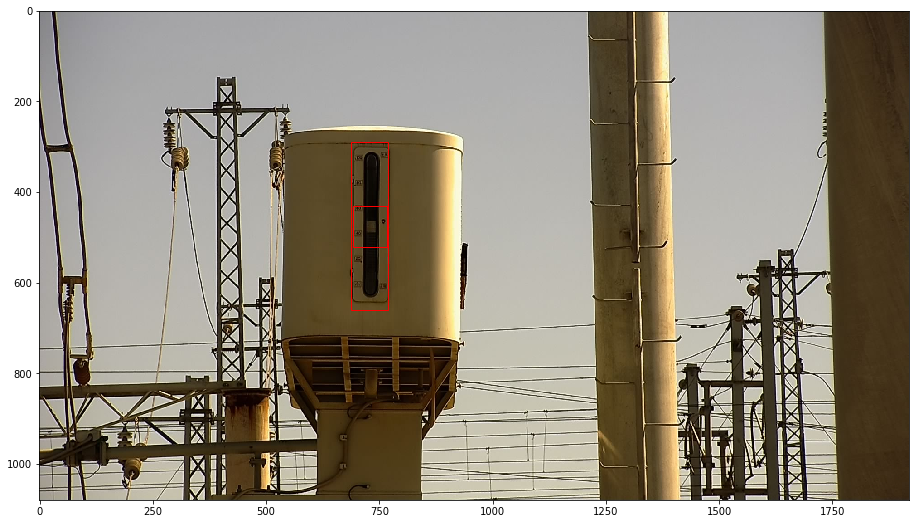

In [65]:
plt.figure(figsize=(16,9))
show_detection2(frame, [boxes[max_bar_idx], boxes[max_piece_idx]])

In [66]:
rect_bar = boxes[max_bar_idx]

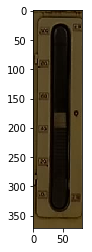

In [67]:
bar_crop = frame[rect_bar[1]:(rect_bar[1]+rect_bar[3]), rect_bar[0]:(rect_bar[0]+rect_bar[2])]
plt.imshow(bar_crop)

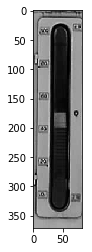

In [68]:
bar_crop_gray = cv.cvtColor(bar_crop, cv.COLOR_RGB2GRAY)
plt.imshow(bar_crop_gray, cmap='gray')

In [69]:
sobelx8u = cv.Sobel(bar_crop_gray,cv.CV_8U,1,0,ksize=5)
sobely8u = cv.Sobel(bar_crop_gray,cv.CV_8U,0,1,ksize=5)

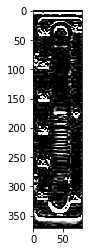

In [70]:
plt.imshow(sobely8u, cmap='gray')

In [76]:
edge_idx = 100+np.argmax(sobely8u[100:].mean(axis=1))
edge_idx

354

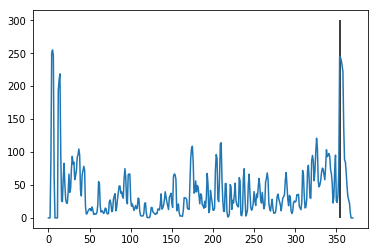

In [78]:
plt.plot(sobely8u.mean(axis=1))
plt.vlines([edge_idx],0,300)

In [79]:
sobely8u.shape

(371, 83)

In [80]:
diff

418

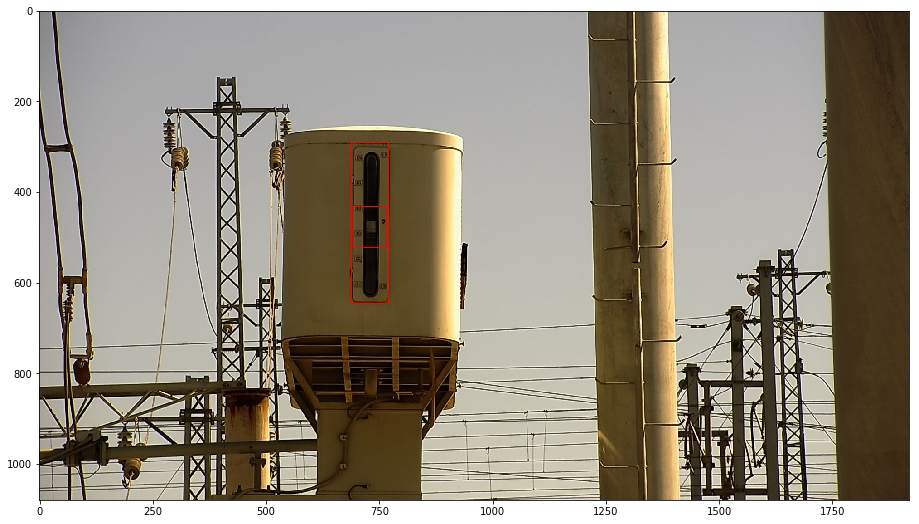

In [82]:
plt.figure(figsize=(16,9))
diff = -(bar_crop_gray.shape[0]-edge_idx)
show_detection2(frame, [boxes[max_bar_idx] + np.array([0,0,0,diff]), boxes[max_piece_idx]])

我们在最高（也就是下面）像素里（取宽度的一半，如这里为42像素）搜索最高点，如果在5像素以内就不做调整。否则取最高点

In [83]:
frame,classIds,confidences,boxes = preprocess('20180508111828.jpg') # multiple box
max_bar_idx, max_piece_idx = extract_max(classIds, confidences)


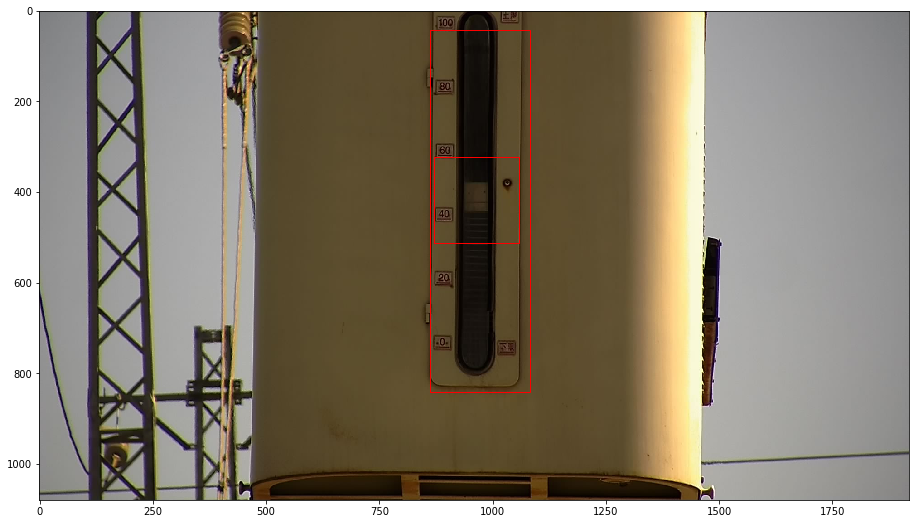

In [84]:
plt.figure(figsize=(16,9))
show_detection2(frame, [boxes[max_bar_idx], boxes[max_piece_idx]])

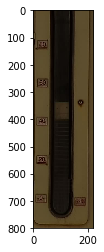

In [85]:
rect_bar = boxes[max_bar_idx]
bar_crop = frame[rect_bar[1]:(rect_bar[1]+rect_bar[3]), rect_bar[0]:(rect_bar[0]+rect_bar[2])]
plt.imshow(bar_crop)

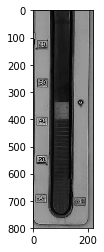

In [86]:
bar_crop_gray = cv.cvtColor(bar_crop, cv.COLOR_RGB2GRAY)
plt.imshow(bar_crop_gray, cmap='gray')

In [87]:
sobely8u = cv.Sobel(bar_crop_gray,cv.CV_8U,0,1,ksize=5)

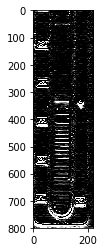

In [88]:
plt.imshow(sobely8u, cmap='gray')

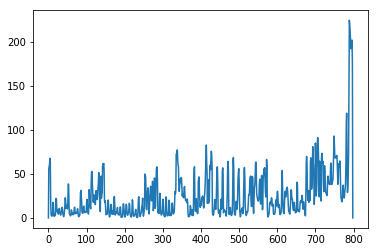

In [89]:
plt.plot(sobely8u.mean(axis=1))

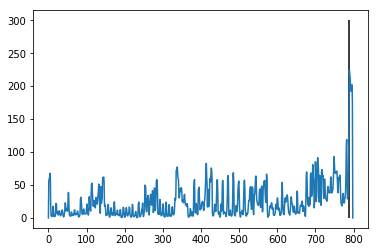

In [90]:
edge_idx = 100+np.argmax(sobely8u[100:].mean(axis=1))
plt.plot(sobely8u.mean(axis=1))
plt.vlines([edge_idx],0,300)

In [91]:
edge_idx,bar_crop_gray.shape

(789, (799, 221))

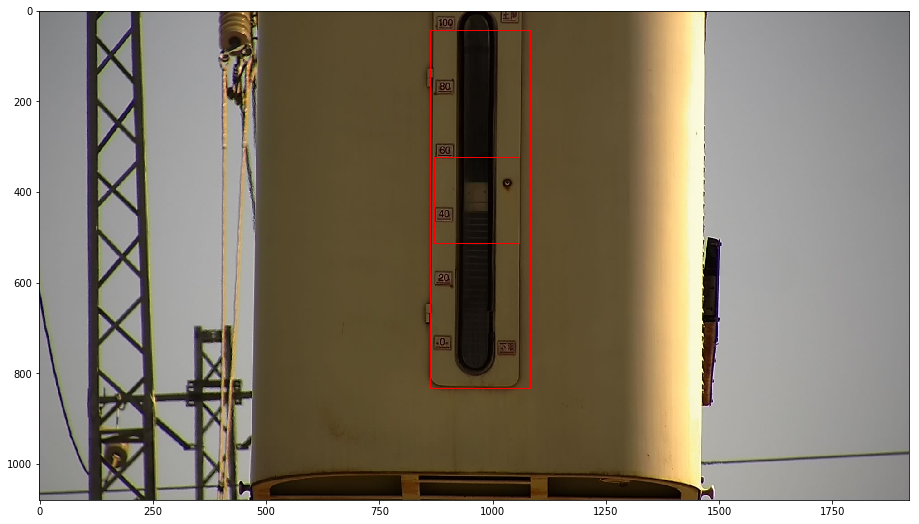

In [92]:
plt.figure(figsize=(16,9))
diff = -(bar_crop_gray.shape[0]-edge_idx)
show_detection2(frame, [boxes[max_bar_idx] + np.array([0,0,0,diff]), boxes[max_piece_idx]])

话说都用上这个校正了，那我们也可以看出上层是不是被截断了（没有那个峰就是被截断了），以及修正左边两边的位置
（但如果不包含左右边就会带来麻烦。）接下来我们要看看这个算法在底部的边有点没有包含时是不是反而带来更大的误差。

In [94]:
col_mean = cv.reduce(sobely8u, 1, cv.REDUCE_AVG)

In [96]:
col_mean.shape

(799, 1)

In [98]:
sobely8u

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  1, ...,  0,  0,  0],
       [ 0,  0,  2, ...,  0,  0,  0],
       ...,
       [16, 15, 12, ..., 81, 63, 54],
       [ 0,  0,  0, ..., 81, 63, 54],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8)

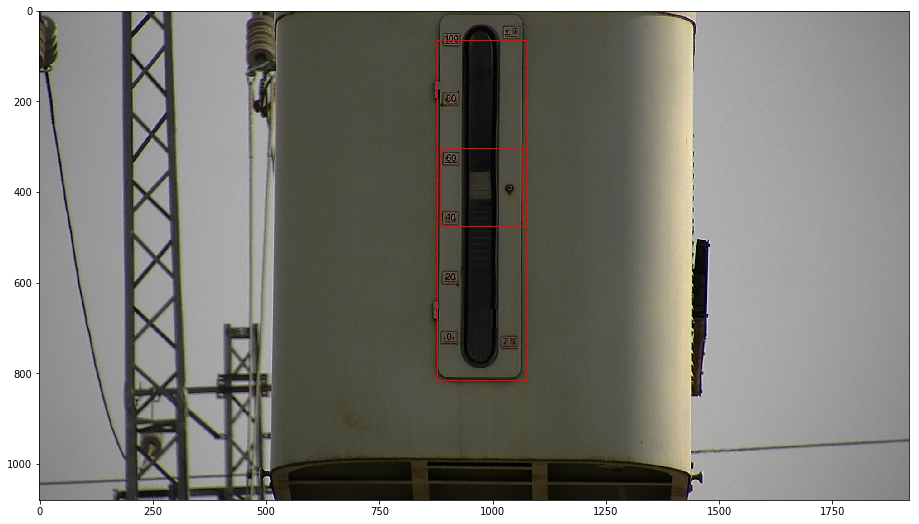

In [99]:
frame,classIds,confidences,boxes = preprocess('20180417104520.jpg') # multiple box
max_bar_idx, max_piece_idx = extract_max(classIds, confidences)

plt.figure(figsize=(16,9))
show_detection2(frame, [boxes[max_bar_idx], boxes[max_piece_idx]])

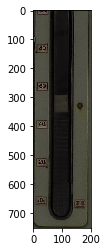

In [100]:
rect_bar = boxes[max_bar_idx]
bar_crop = frame[rect_bar[1]:(rect_bar[1]+rect_bar[3]), rect_bar[0]:(rect_bar[0]+rect_bar[2])]
plt.imshow(bar_crop)

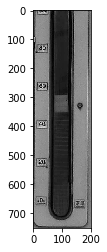

In [101]:
bar_crop_gray = cv.cvtColor(bar_crop, cv.COLOR_RGB2GRAY)
plt.imshow(bar_crop_gray, cmap='gray')

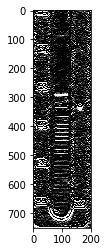

In [102]:
sobely8u = cv.Sobel(bar_crop_gray,cv.CV_8U,0,1,ksize=5)
plt.imshow(sobely8u, cmap='gray')

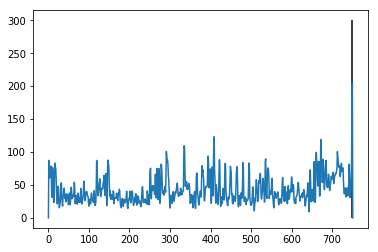

In [103]:
edge_idx = 100+np.argmax(sobely8u[100:].mean(axis=1))
plt.plot(sobely8u.mean(axis=1))
plt.vlines([edge_idx],0,300)

In [104]:
edge_idx

750

In [105]:
sobely8u.shape

(752, 199)